In [1]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)


In [2]:
import random

class FollowingNumber(torch.utils.data.IterableDataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def __iter__(self):
        return self

    def __next__(self):
        a_digit, a_class = random.choice(self.dataset)
        while a_class == 9:
            a_digit, a_class = random.choice(self.dataset)
        
        b_digit, b_class = random.choice(self.dataset)
        while b_class != a_class + 1:
            b_digit, b_class = random.choice(self.dataset)

        return a_digit, b_digit

ds = FollowingNumber(train_mnist)
for a, b in ds:
    print(a.shape, b.shape)
    break

torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


In [3]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, out_channels,
                kernel_size=3, padding=1
            ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                out_channels, out_channels,
                kernel_size=3, padding=1
            ),
            torch.nn.BatchNorm2d(out_channels),
        )
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=1
                ),
                torch.nn.BatchNorm2d(out_channels),
            )
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)

        if self.downsample is not None:
            out = self.downsample(x) + y
        else:
            out = x + y

        return torch.relu(out)


class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            ResidualBlock(1, 16),
            ResidualBlock(16, 32),
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 32),
            ResidualBlock(32, 16),
            ResidualBlock(16, 1),
        )
    
    def forward(self, x):
        y = self.net(x)
        return y

ds = FollowingNumber(train_mnist)
model = ResNet()

for a, b in ds:
    out = model(a.unsqueeze(0))
    print(out.shape)
    break


torch.Size([1, 1, 28, 28])


Loss 0.7252: 100%|██████████| 1000/1000 [00:15<00:00, 66.15it/s]


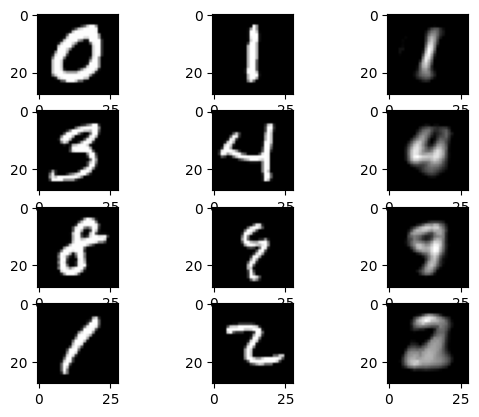

0.7252370715141296


Loss 0.6422: 100%|██████████| 1000/1000 [00:15<00:00, 65.59it/s]


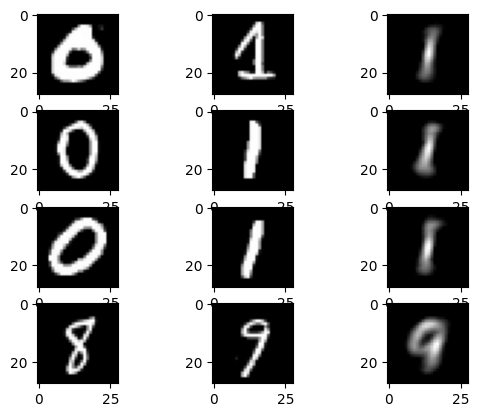

0.6422030925750732


Loss 0.6531: 100%|██████████| 1000/1000 [00:15<00:00, 65.78it/s]


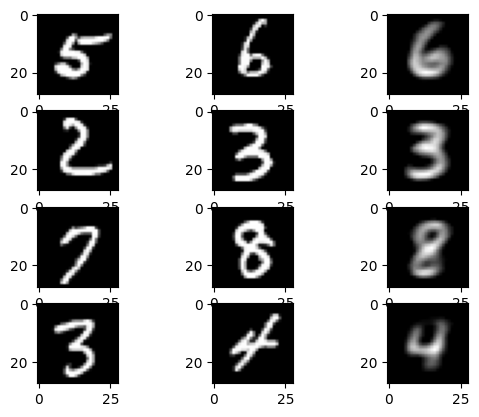

0.653054416179657


In [9]:
from tqdm import trange, tqdm
from matplotlib import pyplot as plt

batches = 1000
ds = FollowingNumber(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=8)
model = ResNet()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to("cuda")

for epoch in range(3):
    bar = tqdm(enumerate(dl), total=batches)
    for i, (a, b) in bar:
        a = a.to("cuda")
        b = b.to("cuda")

        optimizer.zero_grad()
        out = model(a)
        loss = loss_fn(out, b)

        loss.backward()
        optimizer.step()

        bar.set_description(f"Loss {loss.item():.4f}")

        if i >= batches:
            break
    
    fig, axes = plt.subplots(4, 3)
    for i in range(0, 4):
        axes[i, 0].imshow(a[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[i, 1].imshow(b[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[i, 2].imshow(out[i].detach().cpu().numpy().squeeze(), cmap="gray")
    plt.show()

    print(loss.item())

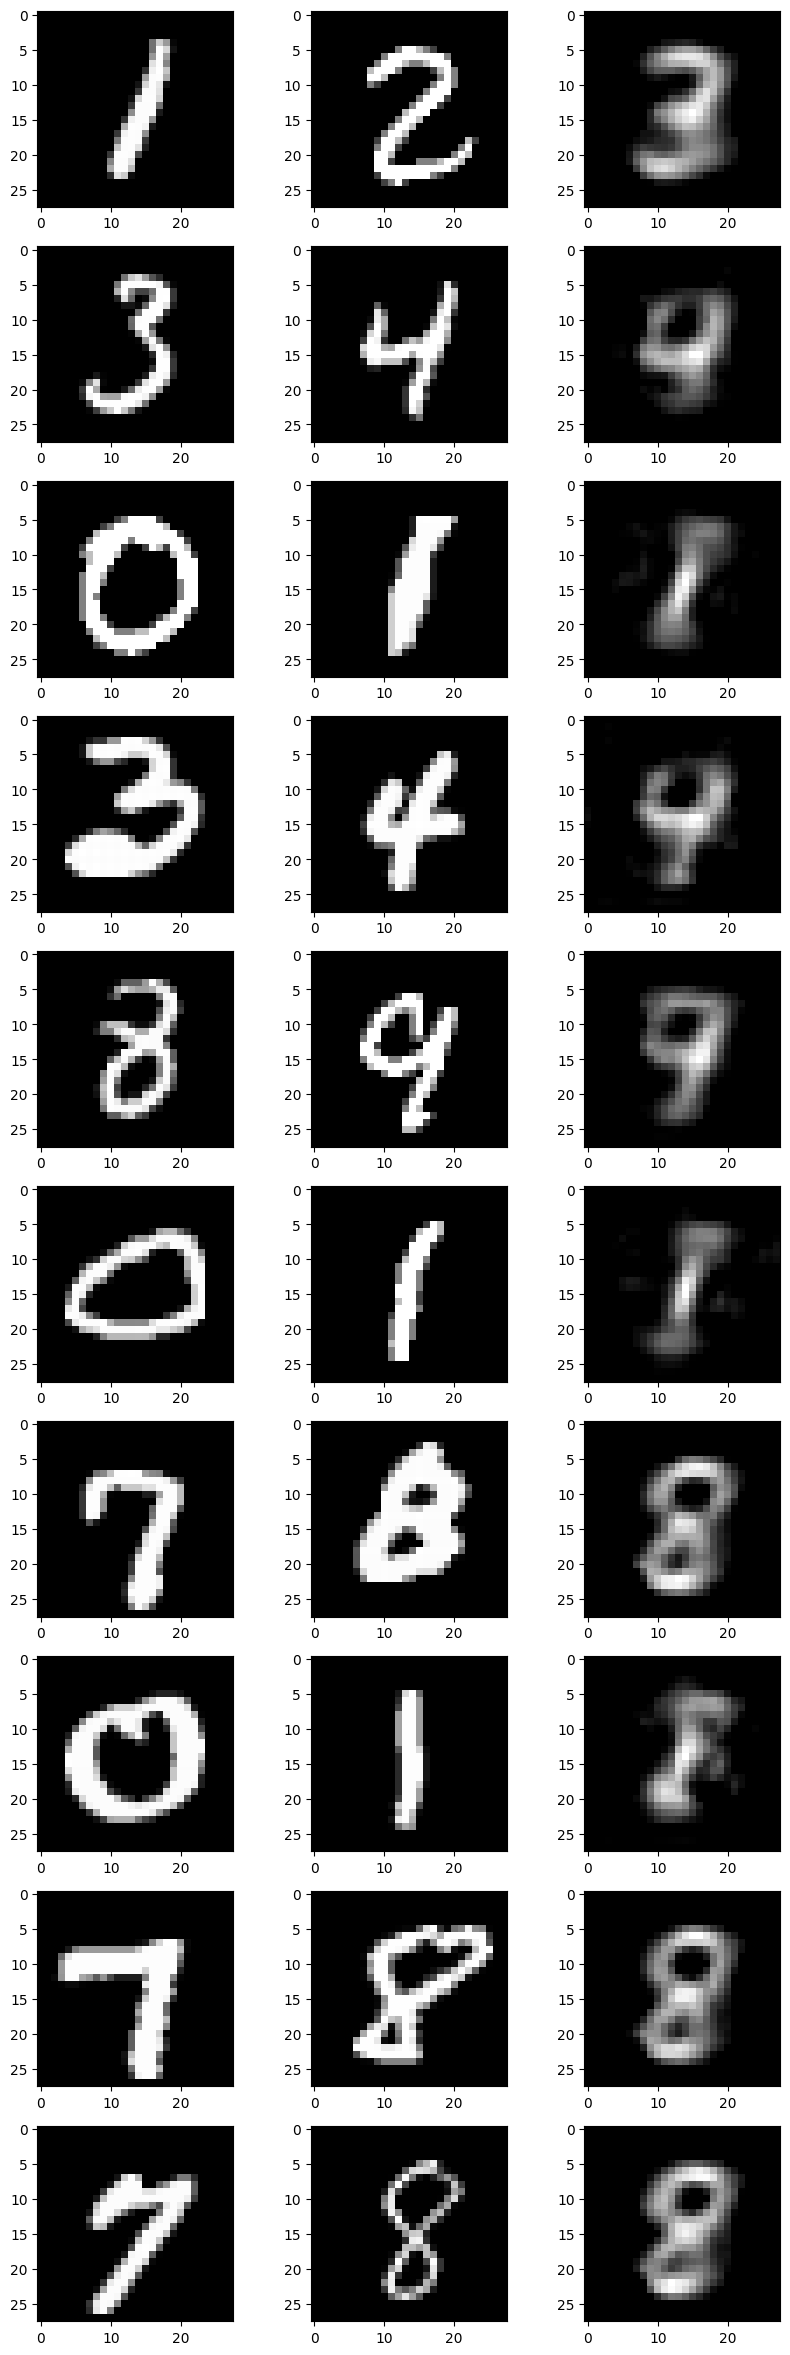

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

ds = FollowingNumber(test_mnist)

fig, axes = plt.subplots(10, 3, figsize=(10, 30))

for i, (a, b) in zip(range(0, 10), ds):
    a = a.to("cuda")
    b = b.to("cuda")
    out = model(a.unsqueeze(0))

    axes[i, 0].imshow(a[0].cpu().numpy(), cmap="gray")
    
    axes[i, 1].imshow(b[0].cpu().numpy(), cmap="gray")
    axes[i, 2].imshow(out[0, 0].detach().cpu().numpy(), cmap="gray")

plt.show()